In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2

def create_dataset(img_folder):
    img_data_array=[]
    class_name=[]
    for dirl in os.listdir(img_folder):
      #Iterate through the flowers directory
        for file in os.listdir(os.path.join(img_folder,dirl)):
          #Iterate through each file in the specific flower category folder
            if any([file.endswith(x) for x in ['.jpeg', '.jpg']]):
                 image_path=os.path.join(img_folder,dirl,file)
                 #read image as RGB
                 image=cv2.imread(image_path,cv2.COLOR_BGR2RGB)
                 #resize image
                 image = cv2.resize(image, dsize=(180,180))
                 #append image data into a list
                 img_data_array.append(image)
                 #append class name of the image into a list
                 class_name.append(dirl)
    return img_data_array,class_name

#Create a dataset
img_data, class_name =create_dataset('/content/drive/My Drive/flowers')



In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

d = {'image_data':img_data,'class':class_name}

#Create dataframe
image_df = pd.DataFrame(d)

#Label encoding for the class names
LE = LabelEncoder()
image_df['category'] = LE.fit_transform(image_df['class'])

image_df.head()

,image_data,class,category
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",tulip,4
1,"[[[56, 64, 48], [15, 36, 23], [31, 41, 32], [3...",tulip,4
2,"[[[15, 46, 18], [17, 47, 14], [18, 46, 17], [1...",tulip,4
3,"[[[99, 91, 66], [4, 30, 26], [4, 10, 6], [33, ...",tulip,4
4,"[[[27, 38, 41], [58, 83, 96], [203, 135, 159],...",tulip,4


In [4]:

from PIL import Image, ImageFilter

gauss_features=[]

#Iterate through the image data and generate gaussian image data for every image
for image in image_df['image_data']:
   gauss_feature = cv2.GaussianBlur(image, (3, 33), 0)
   gauss_features.append(gauss_feature)

#create a new column and store the image gaussian features in it
image_df=image_df.assign(gauss = gauss_features)



In [5]:
#display top rows
image_df.head()

,image_data,class,category,gauss
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",tulip,4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,"[[[56, 64, 48], [15, 36, 23], [31, 41, 32], [3...",tulip,4,"[[[50, 50, 36], [65, 61, 44], [86, 78, 57], [7..."
2,"[[[15, 46, 18], [17, 47, 14], [18, 46, 17], [1...",tulip,4,"[[[28, 63, 26], [28, 63, 27], [28, 64, 28], [2..."
3,"[[[99, 91, 66], [4, 30, 26], [4, 10, 6], [33, ...",tulip,4,"[[[49, 66, 49], [41, 58, 44], [33, 48, 38], [4..."
4,"[[[27, 38, 41], [58, 83, 96], [203, 135, 159],...",tulip,4,"[[[46, 71, 93], [57, 79, 100], [91, 101, 116],..."


In [6]:
#display shape of each gaussian image data
print(image_df.loc[3]['gauss'].shape)

(180, 180, 3)


In [7]:

import numpy as np
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.set_random_seed(2019)


model = tf.keras.models.Sequential([
    #Apply convulution
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , input_shape = (180,180,3)) ,
    #Pooling
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),  
    tf.keras.layers.MaxPooling2D(2,2),
    #Flatten into a 1D features
    tf.keras.layers.Flatten(), 
    #Fully conncted layer to learn bias of each dimenion in the derived feature
    tf.keras.layers.Dense(550,activation="relu"),      #Adding the Hidden layer
    tf.keras.layers.Dropout(0.1,seed = 2019),
    tf.keras.layers.Dense(400,activation ="relu"),
    tf.keras.layers.Dropout(0.3,seed = 2019),
    tf.keras.layers.Dense(300,activation="relu"),
    tf.keras.layers.Dropout(0.4,seed = 2019),
    tf.keras.layers.Dense(200,activation ="relu"),
    tf.keras.layers.Dropout(0.2,seed = 2019),
    tf.keras.layers.Dense(5,activation = "softmax")   #Adding softmax to get class probabilities
])



In [8]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 64)       0

In [9]:
!pip install keras_visualizer

In [10]:
from keras_visualizer import visualizer 
visualizer(model, format='png', view=True)

In [11]:

from tensorflow.keras.optimizers import RMSprop,SGD,Adam
adam=Adam(lr=0.001)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
from sklearn.model_selection import train_test_split

x, x_test, y, y_test = train_test_split(image_df['gauss'].to_list(),image_df['category'].to_list(), stratify=image_df['category'].to_list(), test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(image_df['gauss'].to_list(),image_df['category'].to_list(), stratify=image_df['category'].to_list(),test_size = 0.25,train_size =0.75)


x_train=np.asarray(x_train)
y_train=np.asarray(y_train)
x_test=np.asarray(x_test)
y_test=np.asarray(y_test)
x_val=np.asarray(x_val)
y_val=np.asarray(y_val)



#Class frequency in trainset
import numpy as np
(uniq, freq) = (np.unique(y_train, return_counts=True))
print("Class frequency in Train Set:")
print(np.column_stack((uniq,freq)))

#Class frequency in testset
import numpy as np
(uniq, freq) = (np.unique(y_test, return_counts=True))
print("Class frequency in Test Set:")
print(np.column_stack((uniq,freq)))

#Class frequency in validationset
import numpy as np
(uniq, freq) = (np.unique(y_val, return_counts=True))
print("Class frequency in Validation Set:")
print(np.column_stack((uniq,freq)))


Class frequency in Train Set:
[[  0 193]
 [  1 307]
 [  2 215]
 [  3 208]
 [  4 392]]
Class frequency in Test Set:
[[  0  51]
 [  1  82]
 [  2  57]
 [  3  56]
 [  4 105]]
Class frequency in Validation Set:
[[  0  64]
 [  1 102]
 [  2  72]
 [  3  70]
 [  4 131]]


In [13]:
history = model.fit(x_train,y_train,
                    validation_data=(x_val,y_val),
                    epochs=20,
                    batch_size=128)



Epoch 1/20
11/11 [==============================] - 48s 4s/step - loss: 7.9128 - acc: 0.2274 - val_loss: 1.4959 - val_acc: 0.3303
Epoch 2/20
11/11 [==============================] - 42s 4s/step - loss: 1.5235 - acc: 0.3308 - val_loss: 1.4019 - val_acc: 0.3964
Epoch 3/20
11/11 [==============================] - 42s 4s/step - loss: 1.4387 - acc: 0.3787 - val_loss: 1.3455 - val_acc: 0.4351
Epoch 4/20
11/11 [==============================] - 42s 4s/step - loss: 1.3626 - acc: 0.4129 - val_loss: 1.2500 - val_acc: 0.4784
Epoch 5/20
11/11 [==============================] - 42s 4s/step - loss: 1.3139 - acc: 0.4335 - val_loss: 1.2211 - val_acc: 0.4556
Epoch 6/20
11/11 [==============================] - 42s 4s/step - loss: 1.2468 - acc: 0.4578 - val_loss: 1.2606 - val_acc: 0.4647
Epoch 7/20
11/11 [==============================] - 42s 4s/step - loss: 1.2050 - acc: 0.4897 - val_loss: 1.1187 - val_acc: 0.5535
Epoch 8/20
11/11 [==============================] - 42s 4s/step - loss: 1.1318 - acc: 0.50

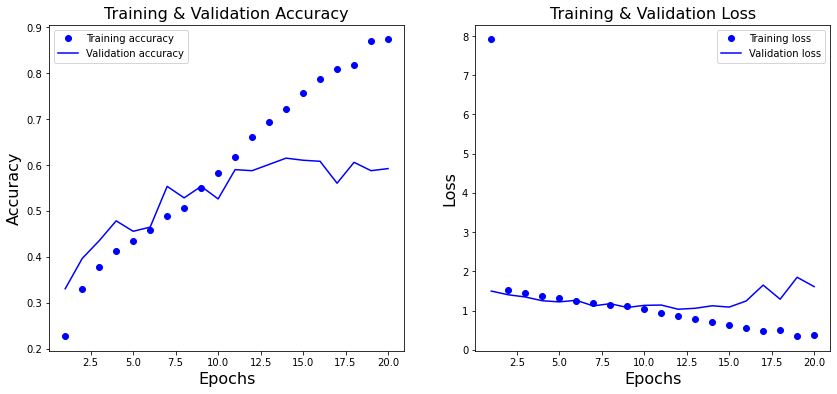

In [14]:
import matplotlib.pyplot as plt
  
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['acc']
val_accuracy = history_dict['val_acc']
  
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

In [20]:

y_pred = np.argmax(model.predict(x_test),axis=1)


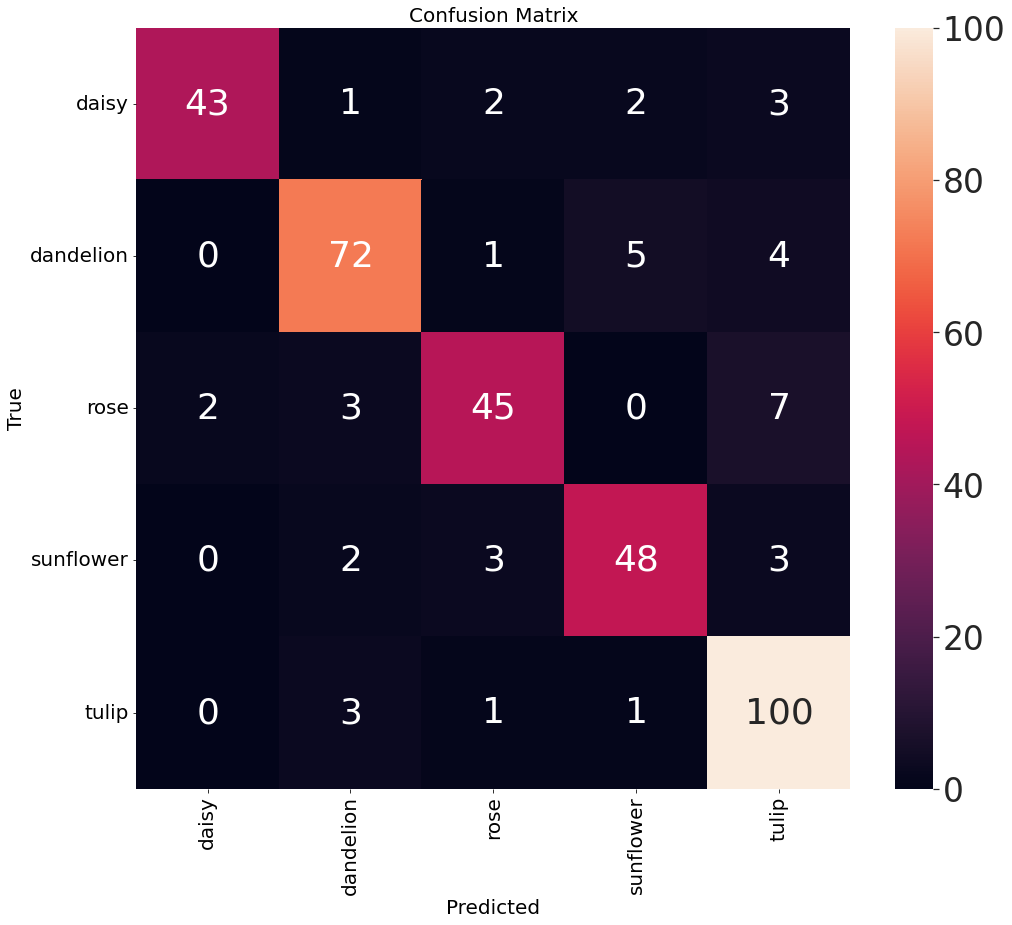

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

labels = LE.classes_
class_names = labels


# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.set(font_scale=3.0)
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 20)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 20)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=20)

plt.show()

ROC AUC score: 0.9160025754452572


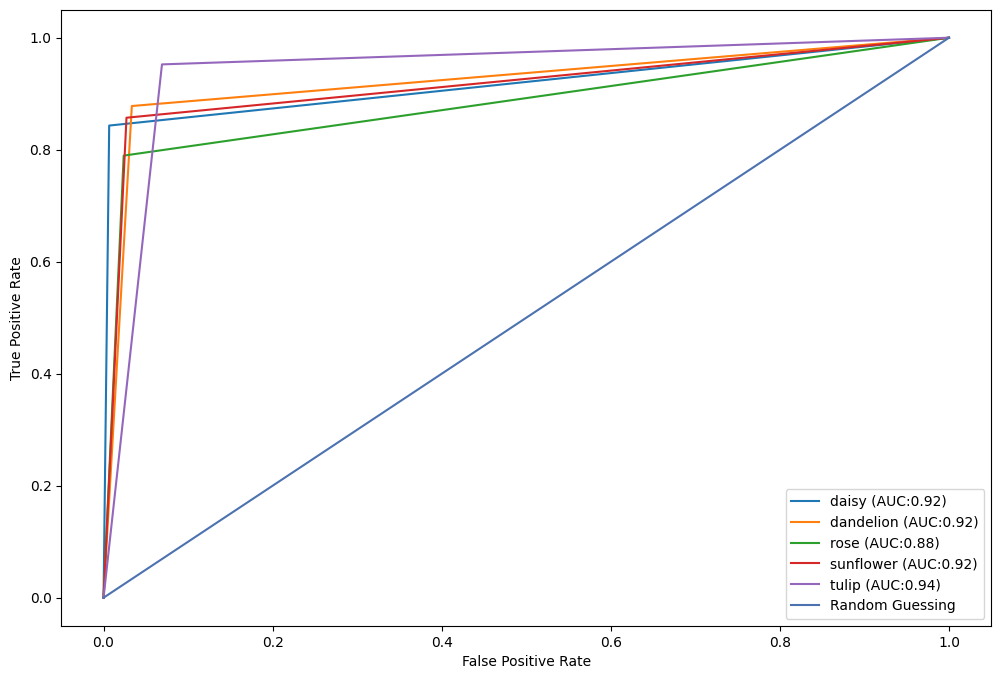

In [43]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= class_names

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_test, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()